In [1]:
import os
import shutil
from pathlib import Path
import requests

import boto3
from botocore.config import Config

import asyncio
import aiohttp
import aiofiles

import nest_asyncio 
nest_asyncio.apply()

import zipfile
import py7zr
import multivolumefile

import uuid
import skimage

import numpy as np
import pandas as pd

from tqdm import tqdm
from tqdm.asyncio import tqdm_asyncio

In [2]:
#DATA = Path("/media/sambhav/30AC4696AC46568E/datasets/urban-feature-extraction")
DATA = Path("C:/Users/hp/Desktop/datasets/urban-feature-extraction")

In [3]:
class DatasetDownloader:
    def __init__(self, downloads:Path, urls:dict):

        # init required directories
        if not (downloads.exists() and downloads.is_dir()):
            downloads.mkdir(exist_ok=True, parents=True)
            print(f"download directory at {downloads}")
        self.download_dir = downloads

        # src_urls is a dictionary such that
        # src_urls[filename:str]  = url:str
        self.src_urls = urls
        
    async def async_download_one_file(self, session, url:str, file_path:Path):
        """Download one file from url and save to disk at file_path"""
        #TODO: How to use tqdm for each coroutine in the notebook
        async with session.get(url, ssl = False) as r:
            #total_size = int(r.headers.get('content-length', 0))
            async with aiofiles.open(file_path, "wb") as f:
                #progress_bar = tqdm(total=total_size, unit="B", unit_scale=True, desc="Downloading")
                async for chunk in r.content.iter_any():
                    await f.write(chunk)
                    #progress_bar.update(len(chunk))

    async def download_files(self, async_download_one_file = None) -> None:
        if not async_download_one_file:
            async_download_one_file = self.async_download_one_file
        #Download files from self.src_urls, skip if already_downloaded
        timeout = aiohttp.ClientTimeout(total = None)
        async with aiohttp.ClientSession(timeout=timeout, cookie_jar=aiohttp.CookieJar()) as session:
            coroutines = list()
            for file_name, url in self.src_urls.items():
                file_path = self.download_dir / file_name 
                coroutines.append(async_download_one_file(session, url, file_path))
            await tqdm_asyncio.gather(*coroutines)   
    
    def validate_download(self, downloaded_file_sizes: dict) -> None:
        #TODO: Implement Validate Downloads
        pass

In [4]:
class DatasetExtractor:

    @staticmethod
    def extract_zip_archive(zip_file_path:Path, target_dir:Path, dirs_to_be_extracted = list()):
        """Extract specified contents from zip archive, extract all contents if not specified"""

        with zipfile.ZipFile(zip_file_path, 'r') as zip:
            #If dirs_to_be_extracted is an empty list, extract entire archive and exit
            if not dirs_to_be_extracted:
                zip.extractall(target_dir); return
            #Otherwise, extract all files under specified dirs
            #For each file in archive, extract if it's under any specified dir
            for member in zip.infolist():
                for foldername in dirs_to_be_extracted:
                    if foldername in member.filename:
                        #TODO: Add tqdm progress bar for extraction
                        zip.extract(member, target_dir)

    @staticmethod    
    def extract_multivolume_archive(multivolume_file_path:Path, target_dir:Path) -> None:
        """Extract all contents of a multivolume 7zip archive""" 

        with multivolumefile.open(multivolume_file_path, mode = 'rb') as multi_archive:
            with py7zr.SevenZipFile(multi_archive, 'r') as archive: # type: ignore
                archive.extractall(path = target_dir)

    @staticmethod
    def validate_extraction(val_dir:Path, val_files: list):
        """Check if val_dir contains all files listed under val_files, return list of missing files"""
        pass

In [5]:
class CropUtil():

    def _read_image(self, path):
        return skimage.io.imread(path) 

    def _read_mask(self, path):
        return skimage.io.imread(path) 

    def _get_pad_amount(self, dimension: int, window: int):
        """Calculate to no of pixels to add to before and after dimension"""
        total_padding = window - (dimension % window)

        if total_padding % 2 == 0:
            after = total_padding // 2
            before = after
        else:
            after = (total_padding // 2) + 1
            before = after - 1
        assert before+after == total_padding 
        return (before, after)
    
    def _pad_3d_array(self, array: np.ndarray, window: int):
        """
        Pad image array s.t. divisible by window\n
        array.shape : (Height, Width, Channels)
        window : side length of square cropping window
        """

        assert array.ndim == 3
        padded_array = np.pad(
            array = array,
            pad_width = (self._get_pad_amount(array.shape[0], window),
                         self._get_pad_amount(array.shape[1], window),
                         (0, 0))
        ) 
        return padded_array
    
    def _get_cropped_view(self, array: np.ndarray, window:int):
        """
        Crop image array s.t. divisible by window\n
        array.shape : (Height, Width, Channels)
        window : side length of square cropping window
        """

        assert array.ndim == 3
        cropped_view = skimage.util.view_as_windows(
            arr_in = array,
            window_shape = (window, window, array.shape[2]),
            step =  (window, window, array.shape[2])).squeeze()
            
        cropped_view = cropped_view.reshape(-1, window, window, array.shape[2])

        return cropped_view

    def _crop_one_scene(self, tile_path: Path, window: int, read_scene):
        scene = read_scene(tile_path) 
        scene = self._pad_3d_array(scene, window)
        scene = self._get_cropped_view(scene, window)
        return scene

    def _save_as_jpeg_100(self, array: np.ndarray, out_path: Path) -> None:
        skimage.io.imsave((out_path.parent / f"{out_path.stem}.jpg"), array, check_contrast = False, **{"quality": 100})

In [6]:
class ContaboStorage():
    def __init__(self, credentials_file: Path = None, bucket_name = None):

        assert (credentials_file.exists() and credentials_file.is_file())

        with open(credentials_file) as credentials:
            credentials = credentials.readlines()[1:]

        def get_key(x: str) ->str:
            return x.split('=')[-1].strip('\n').strip(' ')

        self.s3resource = boto3.resource("s3",
                          endpoint_url = "https://usc1.contabostorage.com",
                          aws_access_key_id = get_key(credentials[0]),
                          aws_secret_access_key = get_key(credentials[1]))

        self.bucket = self.s3resource.Bucket(bucket_name)
        self.prefix = {
            "train_image": "labelled/patches/images",
            "train_mask": "labelled/patches/masks",

            "test_image": "labelled/scenes/images",
            "test_mask": "labelled/scenes/masks",
        }

    def list_files_in_bucket(self):
        for file_obj in self.bucket.objects.all():
            print(file_obj.key)

    def upload_patch(self, patch_path:Path, prefix:str):
        assert patch_path.exists() and patch_path.is_file()

        patch_key = (Path(prefix) / patch_path.name).as_posix()
        self.bucket.Object(patch_key).upload_file(patch_path)
        print(f"Uploaded to {self.bucket.name}/{patch_key}")

    def upload_train_pair(self, file_name, image_dir, mask_dir):
        self.upload_patch(
            patch_path = (image_dir / file_name),
            prefix = self.prefix["train_image"]
        )
        self.upload_patch(
            patch_path = (mask_dir / file_name),
            prefix = self.prefix["train_mask"]
        )

    def upload_test_pair(self, file_name, image_dir, mask_dir):
        self.upload_patch(
            patch_path = (image_dir / file_name),
            prefix = self.prefix["test_image"]
        )
        self.upload_patch(
            patch_path = (mask_dir / file_name),
            prefix = self.prefix["test_mask"]
        )
    
    def download_train_catalog(self, csv_path: Path)
        train_catalog = self.bucket.Object("labelled/metadata/patches.csv")
        if train_catalog: #is an object
            train_catalog.download_file(csv_path)
    
    def upload_train_catalog(self, csv_path: Path):
        train_catalog = self.bucket.Object("labelled/metadata/patches.csv")
        train_catalog.upload_file(csv_path)

In [389]:
class S3StorageEmulator():
    def __init__(self, credentials_file: Path = None, bucket_name = None):

        assert (credentials_file.exists() and credentials_file.is_file())

        DATASETS_ROOT = Path("C:/Users/hp/Desktop/datasets")
        self.bucket = DATASETS_ROOT / bucket_name

        self.prefix = {
            "train_image": "labelled/patches/images",
            "train_mask": "labelled/patches/masks",

            "test_image": "labelled/scenes/images",
            "test_mask": "labelled/scenes/masks",
        }

    def list_files_in_bucket(self):
        for file_path in self.bucket.rglob("*"):
            print(file_path)

    def upload_patch(self, patch_path:Path, prefix:str):
        assert patch_path.exists() and patch_path.is_file()

        patch_key = Path(prefix)
        (self.bucket/patch_key).mkdir(parents=True, exist_ok=True)

        #print(f"Source: {patch_path}")
        #print(f"Destination: {self.bucket / patch_key / patch_path.name}")
        #print(self.bucket / patch_key)
        shutil.copy(patch_path, (self.bucket / patch_key / patch_path.name))

        #print(f"Uploaded to {self.bucket.name}/{patch_key}")
    
    def upload_file(self, bucket_path, disk_path):
        assert disk_path.exists() and disk_path.is_file()
        shutil.copy(disk_path, bucket_path)
    
    def download_file(self, bucket_path, disk_path):
        assert bucket_path.exists() and bucket_path.is_file()
        shutil.copy(bucket_path, disk_path)

    def download_train_catalog(self, csv_path: Path):
        train_catalog = self.bucket / "labelled/metadata/patches.csv"
        try:
            self.download_file(train_catalog, csv_path)
        except:
            return
    
    def upload_train_catalog(self, csv_path: Path):
        train_catalog = self.bucket / "labelled/metadata/patches.csv"
        train_catalog.parent.mkdir(parents = True, exist_ok = True)
        self.upload_file(train_catalog, csv_path)

    def upload_train_pair(self, file_name, image_dir, mask_dir):
        self.upload_patch(
            patch_path = (image_dir / file_name),
            prefix = self.prefix["train_image"]
        )
        self.upload_patch(
            patch_path = (mask_dir / file_name),
            prefix = self.prefix["train_mask"]
        )

    def upload_test_pair(self, file_name, image_dir, mask_dir):
        self.upload_patch(
            patch_path = (image_dir / file_name),
            prefix = self.prefix["test_image"]
        )
        self.upload_patch(
            patch_path = (mask_dir / file_name),
            prefix = self.prefix["test_mask"]
        )

In [390]:
cntb = S3StorageEmulator((Path.home() / ".aws" / "config"), 'building-footprints-dataset')

In [391]:
class InriaETL():

    urls = {
        "aerialimagelabeling.7z.001" : "https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.001",
        "aerialimagelabeling.7z.002" : "https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.002",
        "aerialimagelabeling.7z.003" : "https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.003",
        "aerialimagelabeling.7z.004" : "https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.004",
        "aerialimagelabeling.7z.005" : "https://files.inria.fr/aerialimagelabeling/aerialimagelabeling.7z.005"
    }

    sizes = {
        "aerialimagelabeling.7z.001" : 0,
        "aerialimagelabeling.7z.002" : 0,
        "aerialimagelabeling.7z.003" : 0,
        "aerialimagelabeling.7z.004" : 0,
        "aerialimagelabeling.7z.005" : 0
    }

    locations = ["austin", "chicago", "kitsap", "tyrol-w", "vienna"]
    test_files_list = [f"{location}{num}.tif" for location in locations for num in range(1, 7)]
    train_files_list = [f"{location}{num}.tif" for location in locations for num in range(7, 37)]

    def __init__(self, root: Path):
        self.root_dir = root
        self.download_dir = root / "downloads"

        # Downloaded Images, Masks
        self.d_dataset_dir = root / "AerialImageDataset" / "train"
        self.d_image_dir = self.d_dataset_dir / "images"
        self.d_mask_dir = self.d_dataset_dir / "gt"

        # Test Images, Masks
        self.t_image_dir = self.root_dir / "test" / "images"
        self.t_mask_dir = self.root_dir / "test" / "masks"

        #Images, Masks
        self.image_dir = self.root_dir / "images"
        self.mask_dir = self.root_dir / "masks"


    def download(self):
        downloader = DatasetDownloader(self.download_dir, self.urls)
        asyncio.run(downloader.download_files())
        #await asyncio.create_task(downloader.download_files())
        #downloader.validate_download()

    def extract(self, low_storage_mode:bool):
        extractor = DatasetExtractor()

        #Merge and Extract Dataset Zip
        multivolume_7zip_path = self.download_dir / "aerialimagelabeling.7z"
        dataset_zip_path = self.download_dir / "NEW2-AerialImageDataset.zip"

        extractor.extract_multivolume_archive(multivolume_7zip_path, self.download_dir)
        print(f"Extracted Multivolume Archive to {dataset_zip_path}")

        if low_storage_mode:
            print("Deleting downloaded multi-volume to save storage space")
            for volume in self.download_dir.glob("aerialimagelabeling.7z.*"):
                volume.unlink()

        extractor.extract_zip_archive(dataset_zip_path, self.root_dir, ["train"])
        print(f"Extracted Dataset Archive to {self.root_dir}")

        if low_storage_mode:
            print("Deleting extracted dataset archive to save storage space")
            dataset_zip_path.unlink()

        #extractor.validate_extraction(files_list, dataset_dir)

    def move_test_split(self):
        self.t_image_dir.mkdir(exist_ok=True, parents=True)
        self.t_mask_dir.mkdir(exist_ok=True, parents=True)

        for file_name in self.test_files_list:
            shutil.move((self.d_image_dir / file_name), self.t_image_dir)
            shutil.move((self.d_mask_dir / file_name), self.t_mask_dir)

    @staticmethod
    def read_mask(path:Path):
        return np.expand_dims(skimage.io.imread(path), -1)

    def crop(self, window: int):
        self.image_dir.mkdir(exist_ok=True)
        self.mask_dir.mkdir(exist_ok=True)

        cropper = CropUtil()

        for file_name in self.train_files_list:

            cropped_image_view = cropper._crop_one_scene(
                tile_path = self.d_image_dir / file_name,
                window = window,
                read_scene = cropper._read_image
            )

            cropped_mask_view = cropper._crop_one_scene(
                tile_path = self.d_mask_dir / file_name,
                window = window,
                read_scene = self.read_mask
            )

            for image_crop, mask_crop in zip(cropped_image_view, cropped_mask_view):
                crop_name = str(uuid.uuid4())
                cropper._save_as_jpeg_100(image_crop , (self.image_dir / crop_name))
                cropper._save_as_jpeg_100(mask_crop.squeeze(), (self.mask_dir / crop_name))

    def delete_downloaded_dataset(self):
        shutil.rmtree(self.d_dataset_dir)
        self.d_dataset_dir.parent.rmdir()

    def upload(self, storage: ContaboStorage):
        for file_path in self.mask_dir.glob("*.jpg"):
            storage.upload_train_pair(file_path.name, self.image_dir, self.mask_dir)
        for file_path in self.t_mask_dir.glob("*.tif"):
            storage.upload_test_pair(file_path.name, self.t_image_dir, self.t_mask_dir)
    
    def _add_patches_to_dataframe(self, df: pd.DataFrame):
        new_df = pd.DataFrame({"name": [x.name for x in self.image_dir.rglob("*.jpg")]}) 
        new_df["dataset"] = new_df.name.apply(lambda x: self.root_dir.name) 
        return pd.concat([df, new_df], axis=0).set_index('name')

    def update_train_catalog(self, storage: ContaboStorage):
        #get path to catalog
        train_catalog_path = self.root_dir / "metadata" / "patches.csv"
        train_catalog_path.parent.mkdir(exist_ok=True, parents=True)

        storage.download_train_catalog(train_catalog_path) 
        if train_catalog_path.exists() and train_catalog_path.is_file():
            print("Found Existing Catalog")
            existing_df = pd.read_csv(train_catalog_path)

            #Remove Old Entries
            dataset_view = existing_df[existing_df["dataset"] == self.root_dir.name].index
            existing_df.drop(dataset_view, inplace=True, axis = 0)
            df = self._add_patches_to_dataframe(existing_df)
            df.to_csv(train_catalog_path)

        else:
            df = pd.DataFrame({"name" : list(), 
                               "dataset" : list()})
            df = self._add_patches_to_dataframe(df)
            df.to_csv(train_catalog_path)

        storage.upload_train_catalog(train_catalog_path)

In [413]:
inria = InriaETL(DATA / "inria")
#await inria.download()
#inria.extract(low_storage_mode=True)
#inria.move_test_split()
#inria.crop(512)
#inria.delete_downloaded_dataset()

In [414]:
#inria.upload(cntb)
inria.update_train_catalog(cntb)
#df.loc[patches[0].name].dataset

Found Existing Catalog


In [417]:
class CityOSMETL():
    urls = {
        "berlin.zip": "https://zenodo.org/record/1154821/files/berlin.zip?download=1",
        "chicago.zip": "https://zenodo.org/record/1154821/files/chicago.zip?download=1",
        "paris.zip": "https://zenodo.org/record/1154821/files/paris.zip?download=1",
        "potsdam.zip": "https://zenodo.org/record/1154821/files/potsdam.zip?download=1",
        "tokyo.zip": "https://zenodo.org/record/1154821/files/tokyo.zip?download=1",
        "zurich.zip": "https://zenodo.org/record/1154821/files/zurich.zip?download=1"
    } 

    def __init__(self, root: Path):
        self.root_dir = root
        self.download_dir = root / "downloads"

        self.d_image_dir = self.download_dir / "images"
        self.d_mask_dir = self.download_dir / "masks"

        self.image_dir = self.root_dir / "images"
        self.mask_dir = self.root_dir / "masks"

        self.t_image_dir= self.root_dir / "test" / "images"
        self.t_mask_dir= self.root_dir / "test" / "masks"

    def download(self):
        downloader = DatasetDownloader(self.download_dir, self.urls)
        asyncio.run(downloader.download_files())
    
    def extract(self, low_storage_space:bool):
        extractor = DatasetExtractor()

        print(f"Extracting downloaded archives")
        for zip_file_name in tqdm(self.urls.keys()):
            zip_file_path = self.download_dir / zip_file_name
            extractor.extract_zip_archive(zip_file_path, self.d_image_dir, ["image"])
            extractor.extract_zip_archive(zip_file_path, self.d_mask_dir, ["labels"])

        print(f"Reorganizing file structure")
        self._move_and_rename_files(self.d_image_dir.rglob("*.png"))
        self._move_and_rename_files(self.d_mask_dir.rglob("*.png"))

        if low_storage_space: 
            print(f"Deleting downloaded archives to save storage space")
            for zip_file_name in self.urls.keys():
                zip_file_path = self.download_dir / zip_file_name
                zip_file_path.unlink()
    
    def calculate_train_test_split(self):
        self.files_list = [x.name for x in self.d_image_dir.rglob("*.png")]
        location_numbers = dict()
        for file_name in self.files_list:
            location = file_name.split('.')[0].strip('1234567890')
            if location in location_numbers.keys():
                location_numbers[location].append(self._extract_file_num(file_name))
            else:
                location_numbers[location] = list()

        self.test_files_list = list()
        for location, numbers_list in location_numbers.items():
            for num in sorted(numbers_list)[:int(0.15*len(numbers_list))]:
                self.test_files_list.append(f"{location}{num}.png")
        
        self.train_files_list = list(set(self.files_list).difference(self.test_files_list))

    def move_test_split(self):
        self.t_image_dir.mkdir(exist_ok=True, parents=True)
        self.t_mask_dir.mkdir(exist_ok=True, parents=True)

        for file_name in self.test_files_list:
            shutil.move(self.d_image_dir / file_name, self.t_image_dir)
            shutil.move(self.d_mask_dir / file_name, self.t_mask_dir)
    

    def crop(self, window: int):
        self.image_dir.mkdir(exist_ok=True)
        self.mask_dir.mkdir(exist_ok=True)

        cropper = CropUtil()

        for file_name in self.train_files_list:
            cropped_image_view = cropper._crop_one_scene(
                tile_path = self.d_image_dir / file_name,
                window = window,
                read_scene = cropper._read_image
            )

            cropped_mask_view = cropper._crop_one_scene(
                tile_path = self.d_mask_dir / file_name,
                window = window,
                read_scene = self.read_mask
            )

            for image_crop, mask_crop in zip(cropped_image_view, cropped_mask_view):
                crop_name = str(uuid.uuid4())
                cropper._save_as_jpeg_100(image_crop, (self.image_dir / crop_name))
                cropper._save_as_jpeg_100(mask_crop.squeeze(), (self.mask_dir / crop_name))
    
    def delete_downloaded_dataset(self):
        shutil.rmtree(self.download_dir)

    def upload(self, storage: ContaboStorage):
        for file_path in tqdm(self.mask_dir.glob("*.jpg")):
            storage.upload_train_pair(file_path.name, self.image_dir, self.mask_dir)
        for file_path in tqdm(self.t_mask_dir.glob("*.png")):
            storage.upload_test_pair(file_path.name, self.t_image_dir, self.t_mask_dir)

    def _move_and_rename_files(self, file_paths) -> None:
        for file_path in file_paths:
            shutil.move(file_path, file_path.parents[1] / f"{file_path.stem.split('_')[0]}.png")
            
    def _extract_file_num(self, file_name: str):
        numbers = list()
        for char in file_name:
            if char.isdigit():
                numbers.append(char) 
        return int(''.join(numbers))

    @staticmethod
    def read_mask(path: Path):
        mask = skimage.io.imread(path)[:, :, 2]
        mask = np.where((mask == 0), np.uint8(255), np.uint8(0))
        return np.expand_dims(mask, -1)

    def _add_patches_to_dataframe(self, df: pd.DataFrame):
        new_df = pd.DataFrame({"name": [x.name for x in self.image_dir.rglob("*.jpg")]}) 
        new_df["dataset"] = new_df.name.apply(lambda x: self.root_dir.name) 
        return pd.concat([df, new_df], axis=0).set_index('name')

    def update_train_catalog(self, storage: ContaboStorage):
        #get path to catalog
        train_catalog_path = self.root_dir / "metadata" / "patches.csv"
        train_catalog_path.parent.mkdir(exist_ok=True, parents=True)

        storage.download_train_catalog(train_catalog_path) 
        if train_catalog_path.exists() and train_catalog_path.is_file():
            print("Found Existing Catalog")
            existing_df = pd.read_csv(train_catalog_path)

            #Remove Old Entries
            dataset_view = existing_df[existing_df["dataset"] == self.root_dir.name].index
            existing_df.drop(dataset_view, inplace=True, axis = 0)
            df = self._add_patches_to_dataframe(existing_df)
            df.to_csv(train_catalog_path)

        else:
            df = pd.DataFrame({"name" : list(), 
                               "dataset" : list()})
            df = self._add_patches_to_dataframe(df)
            df.to_csv(train_catalog_path)

        storage.upload_train_catalog(train_catalog_path)

In [418]:
cityosm = CityOSMETL(DATA / "city-osm")
#cityosm.upload(cntb)
cityosm.update_train_catalog(cntb)
#cityosm.extract(True)
#cityosm.calculate_train_test_split()
#cityosm.move_test_split()
#cityosm.crop(512)
#cityosm.delete_downloaded_dataset()

Found Existing Catalog


In [423]:
df = pd.read_csv("C:/Users/hp/Desktop/datasets/building-footprints-dataset/labelled/metadata/patches.csv", index_col=0)
df

,dataset
name,
0007094d-be9e-4dbb-90fa-f523a43ed5df.jpg,inria
000adc5c-5292-46b3-b7cd-408b94d81867.jpg,inria
000fa39d-0e1e-467b-ab13-d7188fb24152.jpg,inria
00110981-c95d-429b-ad0b-ce152ca4afe3.jpg,inria
001237e3-e991-4ac8-ac27-32af8ed282bc.jpg,inria
...,...
fff4f068-c5f6-4e58-ae47-9a8fbbb5d59c.jpg,city-osm
fffb1731-7644-4e6a-9910-946b346d5000.jpg,city-osm
fffb37ee-4eab-4883-89e9-17a062b5bd9e.jpg,city-osm


In [13]:
class ISPRSETL():
    urls = {
        "potsdam.zip": "https://seafile.projekt.uni-hannover.de/f/429be50cc79d423ab6c4/",
        #"toronto.zip": "https://seafile.projekt.uni-hannover.de/f/fc62f9c20a8c4a34aea1/",
        "vaihingen.zip": "https://seafile.projekt.uni-hannover.de/f/6a06a837b1f349cfa749/",
    }
    password = "CjwcipT4-P8g"
    cookie_name = "sfcsrftoken"

    def __init__(self, root: Path):
        self.root_dir = root
        self.download_dir = root / "downloads"

        self.d_image_dir = self.download_dir / "images"
        self.d_mask_dir = self.download_dir / "masks"

        self.image_dir = self.root_dir / "images"
        self.mask_dir = self.root_dir / "masks"

        self.t_image_dir= self.root_dir / "test" / "images"
        self.t_mask_dir= self.root_dir / "test" / "masks"
    
    def download(self):
        downloader = DatasetDownloader(self.download_dir, self.urls)
        asyncio.run(downloader.download_files(self._download_file))

    def extract(self, low_storage_mode):
        extractor = DatasetExtractor 
        self._extract_vaihingen(extractor, low_storage_mode)
        self._extract_potsdam(extractor, low_storage_mode)
    
    def calculate_train_test_split(self):
        self.files_list = [x.name for x in self.d_image_dir.rglob("*.tif")]
        df = pd.DataFrame({"name": self.files_list})
        df["region"] = df.name.apply(lambda x:self._get_file_region(x))

        self.test_files_list = list()
        for region in df.region.unique():
            region_df = df[df["region"] == region]
            self.test_files_list += sorted(list(region_df.name))[:int(0.15*len(region_df))]
        
        self.train_files_list = sorted(list(set(self.files_list).difference(self.test_files_list)))
    
    def move_test_split(self):
        self.t_image_dir.mkdir(exist_ok=True, parents=True)
        self.t_mask_dir.mkdir(exist_ok=True, parents=True)

        for file_name in self.test_files_list:
            shutil.move((self.d_image_dir / file_name), self.t_image_dir)
            shutil.move((self.d_mask_dir / file_name), self.t_mask_dir)

    @staticmethod
    def read_mask(path:Path):
        mask = skimage.io.imread(path)
        mask = np.where(mask[:, :, 1] == 0, np.uint8(255), np.uint8(0))
        return np.expand_dims(mask, -1)

    def crop(self, window: int):
        self.image_dir.mkdir(exist_ok=True)
        self.mask_dir.mkdir(exist_ok=True)

        cropper = CropUtil()

        for file_name in self.train_files_list:

            cropped_image_view = cropper._crop_one_scene(
                tile_path = self.d_image_dir / file_name,
                window = window,
                read_scene = cropper._read_image
            )

            cropped_mask_view = cropper._crop_one_scene(
                tile_path = self.d_mask_dir / file_name,
                window = window,
                read_scene = self.read_mask
            )

            for image_crop, mask_crop in zip(cropped_image_view, cropped_mask_view):
                crop_name = str(uuid.uuid4())
                cropper._save_as_jpeg_100(image_crop, (self.image_dir / crop_name))
                cropper._save_as_jpeg_100(mask_crop.squeeze(), (self.mask_dir / crop_name))

    
    async def _download_file(self, session, url:str, file_path:str) -> None:
        async with session.get(url) as response:
                cookies = session.cookie_jar.filter_cookies(url)
                cookie_value = cookies[self.cookie_name].value

        #async with session.get(url, ssl = False) as get_request:
            #cookies = {self.cookie_name: get_request.cookies.get(self.cookie_name)}
        payload = {"csrfmiddlewaretoken": cookie_value, 
                   "password": self.password}

        async with session.post(url+"?dl=1", data = payload) as r:
           async with aiofiles.open(file_path, "wb") as f:
                async for chunk in r.content.iter_any():
                    await f.write(chunk)

    def _extract_vaihingen(self, extractor, low_storage_mode: bool):
        vaihingen_zip_path = self.download_dir / "vaihingen.zip"
        image_dataset_zip_path = self.download_dir / "Vaihingen" / "ISPRS_semantic_labeling_Vaihingen.zip"
        mask_dataset_zip_path = self.download_dir / "Vaihingen" / "ISPRS_semantic_labeling_Vaihingen_ground_truth_COMPLETE.zip"

        extractor.extract_zip_archive(vaihingen_zip_path, self.download_dir, [image_dataset_zip_path.name, mask_dataset_zip_path.name])
        print("Extracted downloaded archives")

        if low_storage_mode:
            #vaihingen_zip_path.unlink()
            print("Deleting downloaded archive to save storage sapce")

        self.d_image_dir.mkdir(exist_ok=True, parents=True)
        self.d_mask_dir.mkdir(exist_ok=True, parents=True)

        extractor.extract_zip_archive(image_dataset_zip_path, image_dataset_zip_path.parent, ["top"])
        extractor.extract_zip_archive(mask_dataset_zip_path, self.d_mask_dir)
        print("Extracted downloaded dataset")

        if low_storage_mode:
            #image_dataset_zip_path.unlink()
            #mask_dataset_zip_path.unlink()
            print("Deleted extracted archives")

        for image_path in (image_dataset_zip_path.parent / "top").glob("*.tif"):
            shutil.move(image_path, self.d_image_dir)
        print("Moved extracted images and masks")

        if low_storage_mode:
            #shutil.rmtree(image_dataset_zip_path.parent)
            pass
    
    def _extract_potsdam(self, extractor, low_storage_mode: bool):
        potsdam_zip_path = self.download_dir / "potsdam.zip"
        images_zip_path = self.download_dir / "Potsdam" / "2_Ortho_RGB.zip"
        masks_zip_path = self.download_dir / "Potsdam" / "5_Labels_all.zip"

        extractor.extract_zip_archive(potsdam_zip_path, self.download_dir, [images_zip_path.name, masks_zip_path.name])
        if low_storage_mode:
            #potsdam_zip_path.unlink()
            print("Deleted downloaded archive")

        images_temp_dir = images_zip_path.parent / images_zip_path.stem
        extractor.extract_zip_archive(images_zip_path, images_zip_path.parent)

        masks_temp_dir = masks_zip_path.parent / masks_zip_path.stem
        (masks_temp_dir).mkdir(exist_ok=True)
        extractor.extract_zip_archive(masks_zip_path, masks_temp_dir)

        print("Extracted images and masks sub archives")

        if low_storage_mode:
            #images_zip_path.unlink()
            #masks_zip_path.unlink()
            print("Deleted extracted sub archives")

        self.d_image_dir.mkdir(exist_ok=True, parents=True)
        self.d_mask_dir.mkdir(exist_ok=True, parents=True)
        #Copy Images, Masks to Correct Directories
        for image_path in images_temp_dir.glob("*.tif"):
            shutil.move(image_path, self.d_image_dir / image_path.name.replace("_RGB", ""))
        for mask_path in masks_temp_dir.glob("*.tif"):
            shutil.move(mask_path, self.d_mask_dir / mask_path.name.replace("_label", ""))
        print("Moved extracted images and masks")

        if low_storage_mode:
            #shutil.rmtree(images_zip_path.parent)
            print("Cleanup directory structure")

    def _get_file_region(self, file_name):
        if "mosaic" in file_name:
            region = "vaihingen"
        elif "potsdam" in file_name:
            region = "potsdam"
        return region

    def upload(self, storage: ContaboStorage):
        for file_path in tqdm(self.mask_dir.glob("*.jpg")):
            storage.upload_train_pair(file_path.name, self.image_dir, self.mask_dir)
        for file_path in tqdm(self.t_mask_dir.glob("*.png")):
            storage.upload_test_pair(file_path.name, self.t_image_dir, self.t_mask_dir)

    def _add_patches_to_dataframe(self, df: pd.DataFrame):
        new_df = pd.DataFrame({"name": [x.name for x in self.image_dir.rglob("*.jpg")]}) 
        new_df["dataset"] = new_df.name.apply(lambda x: self.root_dir.name) 
        return pd.concat([df, new_df], axis=0).set_index('name')

    def update_train_catalog(self, storage: ContaboStorage):
        #get path to catalog
        train_catalog_path = self.root_dir / "metadata" / "patches.csv"
        train_catalog_path.parent.mkdir(exist_ok=True, parents=True)

        storage.download_train_catalog(train_catalog_path) 
        if train_catalog_path.exists() and train_catalog_path.is_file():
            print("Found Existing Catalog")
            existing_df = pd.read_csv(train_catalog_path)

            #Remove Old Entries
            dataset_view = existing_df[existing_df["dataset"] == self.root_dir.name].index
            existing_df.drop(dataset_view, inplace=True, axis = 0)
            df = self._add_patches_to_dataframe(existing_df)
            df.to_csv(train_catalog_path)

        else:
            df = pd.DataFrame({"name" : list(), 
                               "dataset" : list()})
            df = self._add_patches_to_dataframe(df)
            df.to_csv(train_catalog_path)

        storage.upload_train_catalog(train_catalog_path)

In [14]:
isprs = ISPRSETL(DATA / "isprs")
isprs.extract(False)
isprs.calculate_train_test_split()
isprs.move_test_split()
isprs.crop(512)

(2558, 2818, 1)


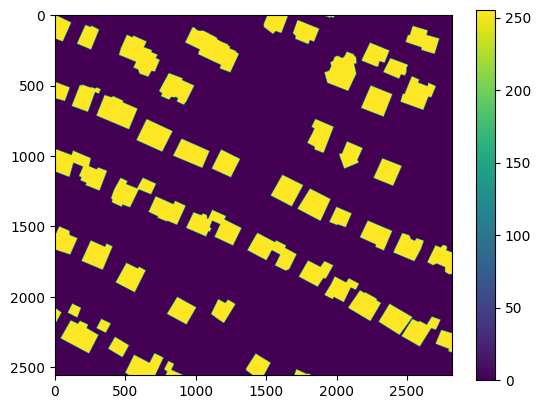

In [49]:
import matplotlib.pyplot as plt
mask = isprs.read_mask(isprs.d_mask_dir / isprs.train_files_list[0])
#mask = np.where(mask[:, :, 1] == 0, 255, 0)
#mask = np.expand_dims(mask, -1)
print(mask.shape)
plt.imshow(mask)
plt.colorbar()